# **Plotting ICESat-2 and CryoSat-2 Freeboards**


<div align="center"><img width="40%"  src='https://raw.githubusercontent.com/nsidc/NSIDC-Data-Tutorials/is2-cryo2/notebooks/ICESat-2_Cloud_Access/img/icesat2-cryosat2.png'/></div>

### **Credits**
This notebook was created by Mikala Beig and Andy Barrett, NSIDC

### **Learning Objectives** 

1. use `earthaccess` to search for ICESat-2 ATL10 data using a spatial filter
2. open cloud-hosted files using direct access to the ICESat-2 S3 bucket; 
3. use cs2eo script to download files into your hub instance
3. load an HDF5 group into an `xarray.Dataset`;  
4. visualize freeboards using `hvplot`.
5. map the locations of ICESat-2 and CryoSat-2 freeboards using `cartopy`

### **Prerequisites**

1. An EC2 instance in the us-west-2 region. **NASA cloud-hosted data are in Amazon Region us-west2. So you also need an EC2 instance in the us-west-2 region.** .
2. An Earthdata Login is required for data access. If you don't have one, you can register for one [here](https://urs.earthdata.nasa.gov/).
3. Experience using cs2eo to query for coincident data.
4. A cs2eo download script for CryoSat-2 data.


### **Tutorial Steps**

#### Query for coincident ICESat-2 and CryoSat-2 data

Using the cs2eo coincident data explorer, query for ATL10 and CryoSat-2, L2, SAR, POCA, Baseline E data products using a spatial and temporal filter.

**Download the basic result metadata and the raw access scripts.**  Upload the ESA download script (SIR_SAR_L2_E_download_script.py) into the folder from which you are running this notebook.

![cs2eo query](./img/ATL10_CS2_L2_SAR_query_med.png)

#### Import Packages

In [1]:
import os
import platform
from ftplib import FTP
import sys


# For searching and accessing NASA data
import earthaccess

# For reading data, analysis and plotting
import xarray as xr
import hvplot.xarray

# For nice printing of python objects
import pprint  

# For plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#downloading files using cs2eo script
from SIR_SAR_L2_E_download_script import download_files

## use your own email here
user_email = 'your email here'
path = './data/'

#### Download CryoSat-2 data to your hub instance

Copy the list of ESA files from within SIR_SAR_L2_E_download_script.py 

In [ ]:
esa_files = ['SIR_SAR_L2/2019/12/CS_LTA__SIR_SAR_2__20191227T110305_20191227T111751_E001.nc', 
             'SIR_SAR_L2/2020/03/CS_LTA__SIR_SAR_2__20200329T163208_20200329T164044_E001.nc', 
             'SIR_SAR_L2/2020/01/CS_LTA__SIR_SAR_2__20200114T203033_20200114T204440_E001.nc', 
             'SIR_SAR_L2/2019/11/CS_LTA__SIR_SAR_2__20191103T134759_20191103T135125_E001.nc', 
             'SIR_SAR_L2/2020/02/CS_LTA__SIR_SAR_2__20200204T191657_20200204T192558_E001.nc', 
             'SIR_SAR_L2/2019/12/CS_LTA__SIR_SAR_2__20191216T215645_20191216T220909_E001.nc', 
             'SIR_SAR_L2/2020/03/CS_LTA__SIR_SAR_2__20200315T065755_20200315T071241_E001.nc', 
             'SIR_SAR_L2/2019/10/CS_LTA__SIR_SAR_2__20191030T135252_20191030T135600_E001.nc', 
             'SIR_SAR_L2/2020/02/CS_LTA__SIR_SAR_2__20200219T081800_20200219T083303_E001.nc', 
             'SIR_SAR_L2/2020/01/CS_LTA__SIR_SAR_2__20200110T203717_20200110T204612_E001.nc', 
             'SIR_SAR_L2/2020/04/CS_LTA__SIR_SAR_2__20200409T053748_20200409T054151_E001.nc', 
             'SIR_SAR_L2/2020/04/CS_LTA__SIR_SAR_2__20200413T053254_20200413T053659_E001.nc', 
             'SIR_SAR_L2/2020/02/CS_LTA__SIR_SAR_2__20200208T191154_20200208T192117_E001.nc', 
             'SIR_SAR_L2/2020/03/CS_LTA__SIR_SAR_2__20200319T065300_20200319T070802_E001.nc', 
             'SIR_SAR_L2/2020/03/CS_LTA__SIR_SAR_2__20200304T175209_20200304T180102_E001.nc', 
             'SIR_SAR_L2/2019/11/CS_LTA__SIR_SAR_2__20191128T122800_20191128T123212_E001.nc', 
             'SIR_SAR_L2/2019/10/CS_LTA__SIR_SAR_2__20191009T150801_20191009T151142_E001.nc', 
             'SIR_SAR_L2/2019/11/CS_LTA__SIR_SAR_2__20191121T231659_20191121T232817_E001.nc', 
             'SIR_SAR_L2/2020/02/CS_LTA__SIR_SAR_2__20200215T082253_20200215T083741_E001.nc', 
             'SIR_SAR_L2/2020/01/CS_LTA__SIR_SAR_2__20200121T094259_20200121T095800_E001.nc', 
             'SIR_SAR_L2/2019/10/CS_LTA__SIR_SAR_2__20191005T151255_20191005T151621_E001.nc', 
             'SIR_SAR_L2/2020/04/CS_LTA__SIR_SAR_2__20200427T150701_20200427T151544_E001.nc', 
             'SIR_SAR_L2/2019/10/CS_LTA__SIR_SAR_2__20191024T004201_20191024T005059_E001.nc', 
             'SIR_SAR_L2/2020/03/CS_LTA__SIR_SAR_2__20200308T174708_20200308T175621_E001.nc', 
             'SIR_SAR_L2/2020/04/CS_LTA__SIR_SAR_2__20200402T162707_20200402T163602_E001.nc']

Download the CryoSat-2 files into your hub instance by calling the download_files function you imported from the script.

In [ ]:
download_files(user_email, esa_files)

Stashing the files in a data folder to keep our notebook directory less cluttered.

In [ ]:
!mv CS_LTA__SIR*.nc data

#### Use `earthaccess` for querying and direct S3 access of ATL10

First we authenticate using `earthaccess`

In [2]:
auth = earthaccess.login()

Then we use a spatial filter to search for ATL10 granules that intersect our area of interest.  This is the same area we used in our cs2eo query above.

In [3]:
# url_list from ATL10 download script provided by cs2eo
on_prem_urls = ['https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL10.006/2020.03.19/ATL10-01_20200319030948_12740601_006_01.h5', 
                'https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL10.006/2019.11.21/ATL10-01_20191121192822_08540501_006_01.h5', 
                'https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL10.006/2019.10.09/ATL10-01_20191009110835_01920501_006_02.h5', 
                'https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL10.006/2019.12.27/ATL10-01_20191227071321_00090601_006_01.h5', 
                'https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL10.006/2020.03.04/ATL10-01_20200304141724_10520601_006_01.h5', 
                'https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL10.006/2020.03.29/ATL10-01_20200329130147_00460701_006_01.h5', 
                'https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL10.006/2019.11.28/ATL10-01_20191128083720_09540501_006_01.h5', 
                'https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL10.006/2020.04.02/ATL10-01_20200402125328_01070701_006_02.h5', 
                'https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL10.006/2019.10.30/ATL10-01_20191030100118_05120501_006_01.h5', 
                'https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL10.006/2020.01.14/ATL10-01_20200114164843_02900601_006_01.h5', 
                'https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL10.006/2020.04.27/ATL10-01_20200427113753_04880701_006_02.h5', 
                'https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL10.006/2019.10.23/ATL10-01_20191023205221_04120501_006_02.h5', 
                'https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL10.006/2019.10.05/ATL10-01_20191005111655_01310501_006_02.h5', 
                'https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL10.006/2020.04.09/ATL10-01_20200409020227_02070701_006_02.h5', 
                'https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL10.006/2020.02.19/ATL10-01_20200219043343_08320601_006_01.h5', 
                'https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL10.006/2020.04.13/ATL10-01_20200413015408_02680701_006_02.h5', 
                'https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL10.006/2020.03.08/ATL10-01_20200308140907_11130601_006_01.h5', 
                'https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL10.006/2020.03.15/ATL10-01_20200315031809_12130601_006_01.h5', 
                'https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL10.006/2019.12.16/ATL10-01_20191216181242_12350501_006_01.h5', 
                'https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL10.006/2020.01.21/ATL10-01_20200121055741_03900601_006_01.h5', 
                'https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL10.006/2020.02.15/ATL10-01_20200215044202_07710601_006_01.h5', 
                'https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL10.006/2020.02.04/ATL10-01_20200204154125_06100601_006_01.h5', 
                'https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL10.006/2020.02.08/ATL10-01_20200208153304_06710601_006_01.h5', 
                'https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL10.006/2020.01.10/ATL10-01_20200110165702_02290601_006_01.h5', 
                'https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL10.006/2019.11.03/ATL10-01_20191103095257_05730501_006_01.h5']

The following function replaces the on prem urls in the ATL10 download script with the equivalent cloud urls for earthaccess to utilize.  This won't be necessary once cs2eo is accessing the cloud copy of the data.

In [4]:
def cloud_atl10_urls(on_prem_urls):
    import re
    urls = []
    for url in on_prem_urls:
        match = re.search(r'/ATL10\.006/(\d{4})\.(\d{2})\.(\d{2})/(ATL10-.*\.h5)', url)
        if match:
            year, month, day, filename = match.groups()
            cloud_url = f'https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/ATLAS/ATL10/006/{year}/{month}/{day}/{filename}'
            urls.append(cloud_url)
    return urls

new_urls = cloud_atl10_urls(on_prem_urls)

# This is due a bug in the most recent version.
earthaccess.__store__.in_region = False
icesat2_files = earthaccess.open(new_urls)

QUEUEING TASKS | :   0%|          | 0/25 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/25 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/25 [00:00<?, ?it/s]

We use earthaccess.open() to directly access the ATL10 files within their S3 bucket.  earthaccess.open() creates a file-like object, which is required because AWS S3 uses object storage, and we need to create a virtual file system to work with the HDF5 library.

We can use xarray to examine the contents of our files (one group at a time).

In [5]:
ds_is2 = xr.open_dataset(icesat2_files[1], group='gt2r/freeboard_segment')
ds_is2

<xarray.Dataset> Size: 4MB
Dimensions:               (delta_time: 65982)
Coordinates:
  * delta_time            (delta_time) datetime64[ns] 528kB 2019-11-21T19:48:...
    latitude              (delta_time) float64 528kB ...
    longitude             (delta_time) float64 528kB ...
Data variables:
    beam_fb_confidence    (delta_time) float32 264kB ...
    beam_fb_height        (delta_time) float32 264kB ...
    beam_fb_quality_flag  (delta_time) int8 66kB ...
    beam_fb_unc           (delta_time) float32 264kB ...
    beam_refsurf_ndx      (delta_time) int32 264kB ...
    geoseg_beg            (delta_time) int32 264kB ...
    geoseg_end            (delta_time) int32 264kB ...
    height_segment_id     (delta_time) int32 264kB ...
    seg_dist_x            (delta_time) float64 528kB ...
Attributes:
    Description:  Contains freeboard estimate and associated parameters compu...
    data_rate:    Data within this group are stored at the variable individua...

And we can use hvplot to plot one of the variables within that group.

In [6]:
ds_is2['beam_fb_height'].hvplot(kind='scatter', s=2)

:Scatter   [longitude]   (beam_fb_height)

#### Open and plot downloaded CryoSat-2 data 

We need a list of the downloaded CryoSat-2 files.

In [7]:
downloaded_files = os.listdir(path)
downloaded_files

['CS_LTA__SIR_SAR_2__20200110T203717_20200110T204612_E001.nc',
 'CS_LTA__SIR_SAR_2__20200308T174708_20200308T175621_E001.nc',
 'CS_LTA__SIR_SAR_2__20200204T191657_20200204T192558_E001.nc',
 'CS_LTA__SIR_SAR_2__20200413T053254_20200413T053659_E001.nc',
 'CS_LTA__SIR_SAR_2__20191005T151255_20191005T151621_E001.nc',
 'CS_LTA__SIR_SAR_2__20191121T231659_20191121T232817_E001.nc',
 'CS_LTA__SIR_SAR_2__20200121T094259_20200121T095800_E001.nc',
 'CS_LTA__SIR_SAR_2__20200215T082253_20200215T083741_E001.nc',
 'CS_LTA__SIR_SAR_2__20200329T163208_20200329T164044_E001.nc',
 'CS_LTA__SIR_SAR_2__20191030T135252_20191030T135600_E001.nc',
 'CS_LTA__SIR_SAR_2__20200319T065300_20200319T070802_E001.nc',
 'CS_LTA__SIR_SAR_2__20191216T215645_20191216T220909_E001.nc',
 'CS_LTA__SIR_SAR_2__20191009T150801_20191009T151142_E001.nc',
 'CS_LTA__SIR_SAR_2__20200315T065755_20200315T071241_E001.nc',
 'CS_LTA__SIR_SAR_2__20200402T162707_20200402T163602_E001.nc',
 'CS_LTA__SIR_SAR_2__20200409T053748_20200409T054151_E0

We use xarray to access the contents of our netcdf file.  In this case, we are not "streaming" data from an S3 bucket, but are accessing the data locally.

In [8]:
ds_cs2 = xr.open_dataset(path + downloaded_files[0])
ds_cs2

<xarray.Dataset> Size: 3MB
Dimensions:                           (time_cor_01: 596, time_20_ku: 11905)
Coordinates:
    lat_01                            (time_cor_01) float64 5kB ...
    lat_poca_20_ku                    (time_20_ku) float64 95kB ...
    lon_01                            (time_cor_01) float64 5kB ...
    lon_poca_20_ku                    (time_20_ku) float64 95kB ...
  * time_20_ku                        (time_20_ku) datetime64[ns] 95kB 2020-0...
  * time_cor_01                       (time_cor_01) datetime64[ns] 5kB 2020-0...
Data variables: (12/54)
    alt_01                            (time_cor_01) float64 5kB ...
    echo_avg_numval_20_ku             (time_20_ku) float32 48kB ...
    flag_cor_applied_20_ku            (time_20_ku) float64 95kB ...
    flag_cor_err_01                   (time_cor_01) float64 5kB ...
    flag_instr_conf_rx_str_in_use_01  (time_cor_01) float32 2kB ...
    flag_instr_mode_op_20_ku          (time_20_ku) float32 48kB ...
    ...                                ...
    ssha_interp_20_ku                 (time_20_ku) float64 95kB ...
    ssha_interp_numval_20_ku          (time_20_ku) float32 48kB ...
    ssha_interp_rms_20_ku             (time_20_ku) float64 95kB ...
    surf_type_20_ku                   (time_20_ku) float32 48kB ...
    swh_ocean_01_ku                   (time_cor_01) float64 5kB ...
    wind_speed_alt_01_ku              (time_cor_01) float64 5kB ...
Attributes: (12/101)
    product_name:                 CS_LTA__SIR_SAR_2__20200110T203717_20200110...
    processing_stage:             LTA_
    reference_document:           CS-RS-ACS-ESL-5265 2.1
    doi:                          10.5270/CR2-388fb81
    acquisition_station:          Kiruna              
    mission:                      Cryosat
    ...                           ...
    xref_surf_type:               CS_OPER_AUX_LS_MAP_00000000T000000_99999999...
    xref_tidal_load:              CS_OPER_AUX_TDLOAD_00000000T000000_99999999...
    xref_u_wind:                  CS_OPER_AUX_U_WIND_20200110T180000_20200110...
    xref_uso:                     CS_OPER_AUX_DORUSO_20100411T040029_20211117...
    xref_v_wind:                  CS_OPER_AUX_V_WIND_20200110T180000_20200110...
    xref_wet_trop:                CS_OPER_AUX_WETTRP_20200110T180000_20200110...

In [9]:
ds_cs2['radar_freeboard_20_ku'].hvplot(kind='scatter', s=2)

:Scatter   [time_20_ku]   (radar_freeboard_20_ku)

#### Plot ICESat-2 and CryoSat-2 Freeboards on same map

Here we're plotting one file from each data set to save time.

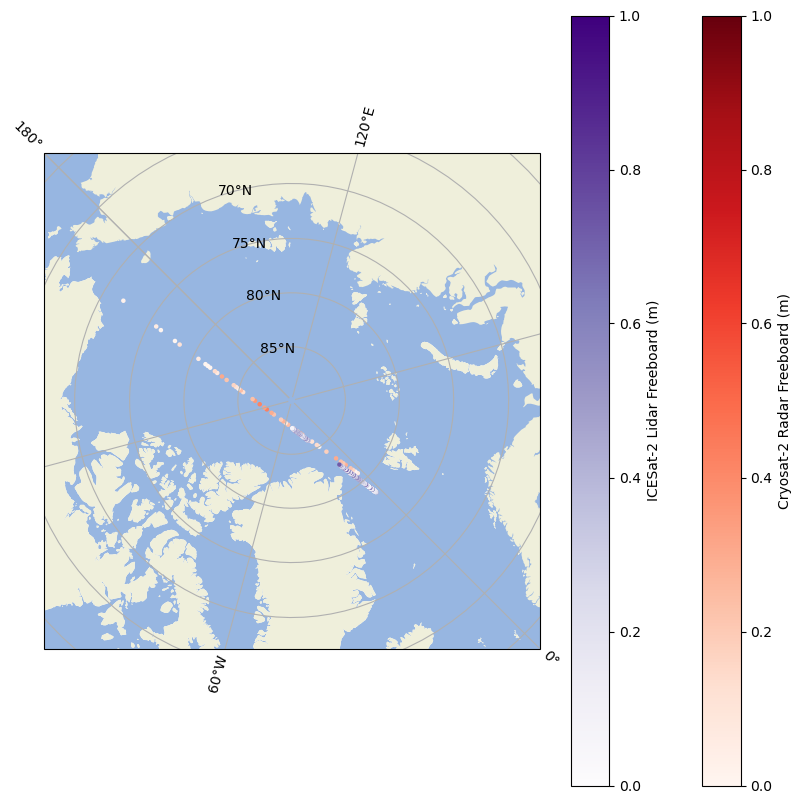

In [16]:
projection = ccrs.Stereographic(central_latitude=90.,
                                central_longitude=-45.,
                                true_scale_latitude=70.)
extent = [-2500000.000, 2500000., -2500000., 2500000.000]


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection=projection)
ax.set_extent(extent, projection)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)
ax.gridlines(draw_labels=True)

vmin = 0.
vmax = 1.

# Plot Cryosat freeboard
cs2_img = ax.scatter(ds_cs2.lon_poca_20_ku, ds_cs2.lat_poca_20_ku, 5,
                        c=ds_cs2.radar_freeboard_20_ku, 
                        vmin=vmin, vmax=vmax,  # Set max and min values for plotting
                        cmap='Reds',   # shading='auto' to avoid warning
                        transform=ccrs.PlateCarree())  # coords are lat,lon but map if NPS 

# Plot IS2 freeboard 
is2_img = ax.scatter(ds_is2.longitude, ds_is2.latitude, 5,
                     c=ds_is2.beam_fb_height, 
                     vmin=vmin, vmax=vmax,  
                     cmap='Purples', 
                     transform=ccrs.PlateCarree())

# Add colorbars
fig.colorbar(cs2_img, label='Cryosat-2 Radar Freeboard (m)')
fig.colorbar(is2_img, label='ICESat-2 Lidar Freeboard (m)')

Here we're plotting several ICESat-2 and CryoSat-2 files at a time.  This takes a few minutes to render.

ValueError: 'c' argument has 11905 elements, which is inconsistent with 'x' and 'y' with size 120.

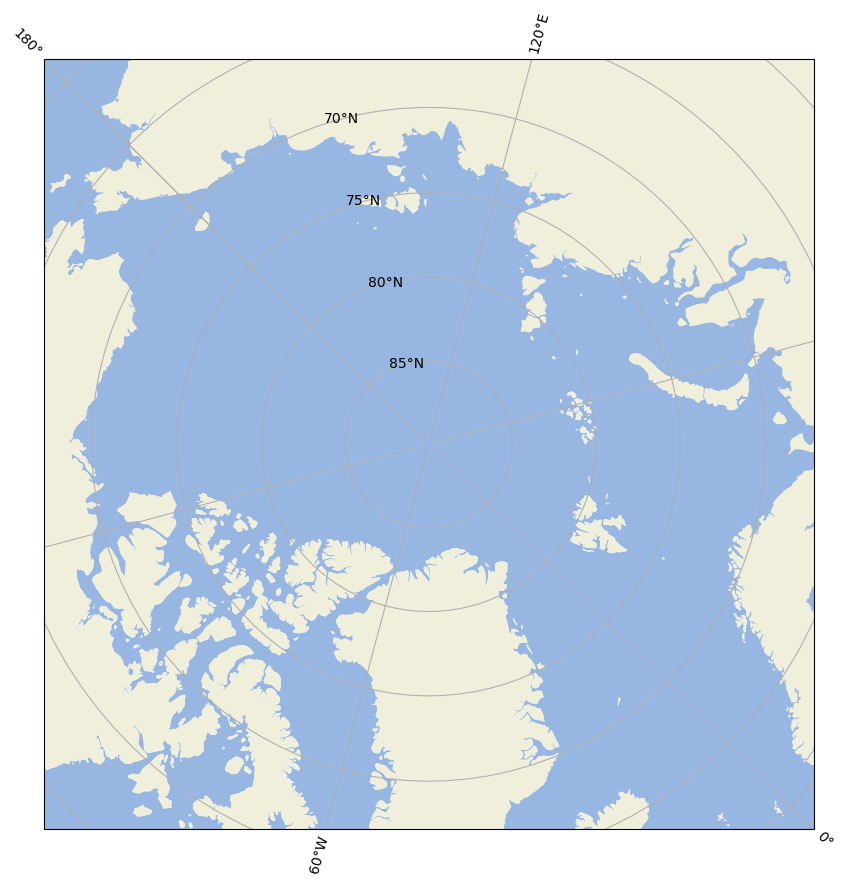

In [15]:
%%time

# NSIDC WGS84 Polar Stereographic 
projection = ccrs.Stereographic(central_latitude=90.,
                                central_longitude=-45.,
                                true_scale_latitude=70.)
extent = [-2500000.000, 2500000., -2500000., 2500000.000]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection=projection)
ax.set_extent(extent, projection)
# ax.coastlines()
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)

ax.gridlines(draw_labels=True)

vmin = 0.
vmax = 1.

# Plot CryoSat-2 freeboards
for fp in downloaded_files:
    ds = xr.open_dataset(path + fp)
    cs2= plt.scatter(ds.lon_poca_20_ku[::100], ds.lat_poca_20_ku[::100], 5,
                    c=ds.radar_freeboard_20_ku[::100], cmap="Reds",
                     vmin=vmin, vmax=vmax,
                    transform=ccrs.PlateCarree())

# Plot ICESat-2 freeboards
for fp in icesat2_files:
    ds = xr.open_dataset(fp, group='gt2r/freeboard_segment')
    is2 = plt.scatter(ds.longitude[::100], ds.latitude[::100], 5,
                      c=ds.beam_fb_height[::100], cmap="Purples",
                     vmin=vmin, vmax=vmax,
                      transform=ccrs.PlateCarree())
    
fig.colorbar(cs2, label="CryoSat-2 Radar Freeboard (m)")
fig.colorbar(is2, label="ICESat-2 Lidar Freeboard (m)")
